### Demo notebook illustrating common usage

## Supported Microscopes/Algorithms
* **EPFL** Challenge:
  * epflreader.EPFLReader('data.csv')
  * [SOURCE](http://bigwww.epfl.ch/smlm/challenge2016/datasets/MT0.N1.HD/Oracle-AS/index.html)
* **Leica GSD**
  * gsd.GSDReader('test.bin') # with test.desc in same folder,
  * gsdreader.GSDReader('test.ascii', preprocess=True, binary=False) # ASCII format
  * (needs pixel to nm conversion (e.g. *160 nm /px) : obj.points *= X
  * [SOURCE](https://www.leica-microsystems.com/products/light-microscopes/p/leica-sr-gsd-3d/)
* **Tafteh et al** dSTORM with z-drift correction (LSI - UBC)
  * dlpreader.DlpReader('test.3dlp')
  * [SOURCE](https://onlinelibrary.wiley.com/doi/abs/10.1002/jbio.201500140)
* Rainstorm
  * db = rainstormreader.RainStormReader('data.csv') # Automatically finds pixel to nm
  * [SOURCE](https://titan.physx.u-szeged.hu/~adoptim/?page_id=582)
* Abbelight
  * ab = abbelightreader.AbbelightReader('data.csv') # in Nm
  * [SOURCE](https://www.abbelight.com/)

In [1]:
from smlmvis import gsdreader
from smlmvis import vtuwriter
from smlmvis import abbelightreader
import os
import filecmp
from smlmvis import epflreader
import os
import seaborn as sns
import tempfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from scipy.spatial import Delaunay
from scipy.spatial import distance
import itertools

### Let's use the EPFL challenge dataset
* [source](http://bigwww.epfl.ch/smlm/challenge2016/datasets/MT0.N1.HD/sample/activations.csv)
* All rights reserved to original creators

#### Create temporary directory

In [2]:
_outdir = tempfile.TemporaryDirectory()
outdir = _outdir.name

### Download and save the file

In [3]:
url = "http://bigwww.epfl.ch/smlm/challenge2016/datasets/MT0.N1.HD/sample/activations.csv"
urllib.request.urlretrieve(url, os.path.join(outdir, 'test.csv'))

('/tmp/tmpcsi69lqz/test.csv', <http.client.HTTPMessage at 0x7f3b094a6910>)

### Decode the data

In [4]:
challenge_data = epflreader.EPFLReader(os.path.join(outdir, 'test.csv'))

### Reader objects
* obj.points : Nx3 float64 xyz coordinates in nm
* obj.values : metadata from microscope (intensity, ...)
* obj.value_names : describes entries in obj.values

### Check the statistics of the data

## Plot Intensity over frame nr

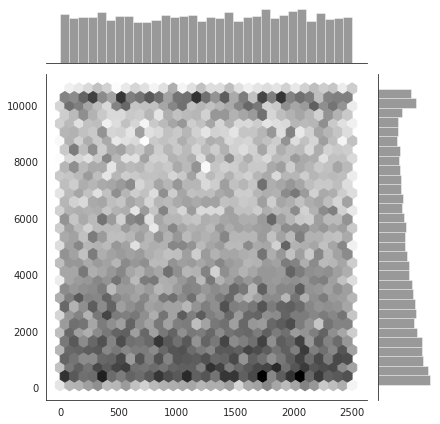

In [5]:
names = challenge_data.value_names
assert('intensity ' == names[-1])
with sns.axes_style("white"):
    sns.jointplot(x=challenge_data.values[:,0], y=challenge_data.values[:,-1], kind="hex", color="k")

#### Let's look at the focal plane (Z)

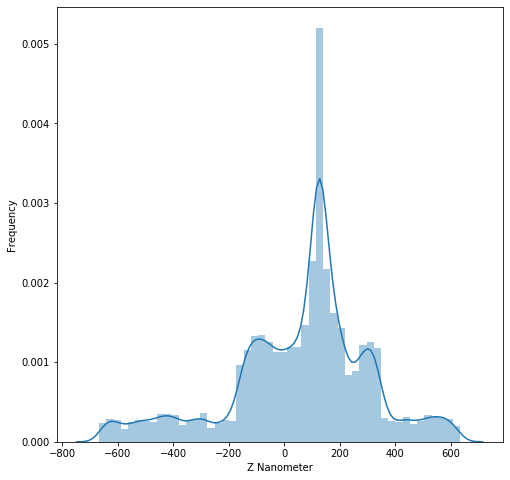

In [6]:
f, a = plt.subplots(1, figsize=(8,8))
sns.distplot(challenge_data.points[:,2], ax=a)
plt.xlabel("Z Nanometer")
plt.ylabel("Frequency")
f.savefig(os.path.join(outdir, 'focal.svg'))

#### X/Y

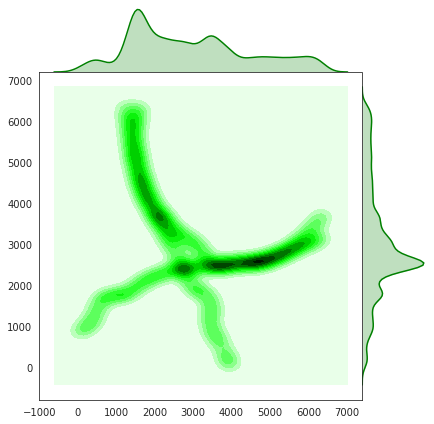

In [8]:
with sns.axes_style("white"):
    sns.jointplot(x=challenge_data.points[:,0], y=challenge_data.points[:,1], kind="kde", space=0, color="g");

### Write the data to VTU for visualization

In [9]:
vtuwriter.VtuWriter(os.path.join(outdir, 'test'), challenge_data.points, challenge_data.values)
## This creates a 'test.vtu' file which you can open with Paraview

### Check with a reference file

In [10]:
url2 = 'http://vault.sfu.ca/index.php/s/NMhjJmaAWfw7sAa/download'
urllib.request.urlretrieve(url2, os.path.join(outdir, 'testref.vtu'))
assert(filecmp.cmp(os.path.join(outdir, 'test.vtu'), os.path.join(outdir, 'testref.vtu'), shallow=False))

### Compute an Alpha Shape

In [11]:
from scipy.spatial import Delaunay
from scipy.spatial import distance
import itertools
pts = challenge_data.points.copy()
G = Delaunay(pts, qhull_options="QJ")
tetras = G.simplices
tetrapoints = G.points[tetras]
distances = np.empty((tetrapoints.shape[0]))
for i,tp in enumerate(tetrapoints):
    iters = list(itertools.combinations(tp, 2))
    dsts = [distance.euclidean(x,y) for x,y in iters]
    distances[i] = max(dsts)

In [12]:
m = np.mean(distances)
s = np.std(distances)
vtuwriter.GraphWriter(os.path.join(outdir, 'full'), G.points, challenge_data.values[:,-1], tetras.copy())
vtuwriter.GraphWriter(os.path.join(outdir, 'alpha'), G.points, challenge_data.values[:,-1], tetras[distances <= m - s/8].copy())
vtuwriter.GraphWriter(os.path.join(outdir, 'alpha_fi'), G.points, challenge_data.values[:,-3], tetras[distances <= m - s/8].copy())


In [15]:
print(outdir)

/tmp/tmpcsi69lqz


### Visualize with Paraview
* Needs paraview installed
* When opening paraview
  * File
  * Load State
  * Select "Load State Data file options"
  * 'Search files under specific directory'
  * Select ./testdata

![Paraview](./example.png "Example")

In [12]:
import subprocess
# Ensure paraview is installed
# Opens a new window
subprocess.run(["paraview", "./testdata/test.pvsm"])

CompletedProcess(args=['paraview', './testdata/test.pvsm'], returncode=0)